**Importando bibliotecas e mostrando as primeiras linhas**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, r2_score, mean_squared_error
from xgboost import XGBRegressor

In [2]:

df = pd.read_csv('/content/drive/MyDrive/Datasets/Exam_Score_Prediction.csv')

df.head()

,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   student_id        20000 non-null  int64  
 1   age               20000 non-null  int64  
 2   gender            20000 non-null  object 
 3   course            20000 non-null  object 
 4   study_hours       20000 non-null  float64
 5   class_attendance  20000 non-null  float64
 6   internet_access   20000 non-null  object 
 7   sleep_hours       20000 non-null  float64
 8   sleep_quality     20000 non-null  object 
 9   study_method      20000 non-null  object 
 10  facility_rating   20000 non-null  object 
 11  exam_difficulty   20000 non-null  object 
 12  exam_score        20000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 2.0+ MB


In [4]:
df.describe()

,student_id,age,study_hours,class_attendance,sleep_hours,exam_score
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000
mean,10000.504600,20.473300,4.007604,70.017365,7.00856,62.513225
std,5773.654959,2.284458,2.308313,17.282262,1.73209,18.908491
min,1.000000,17.000000,0.080000,40.600000,4.10000,19.599000
25%,5000.750000,18.000000,2.000000,55.100000,5.50000,48.800000
50%,10000.500000,20.000000,4.040000,69.900000,7.00000,62.600000
75%,15000.250000,22.000000,6.000000,85.000000,8.50000,76.300000
max,20001.000000,24.000000,7.910000,99.400000,9.90000,100.000000


<Axes: xlabel='exam_score', ylabel='Density'>

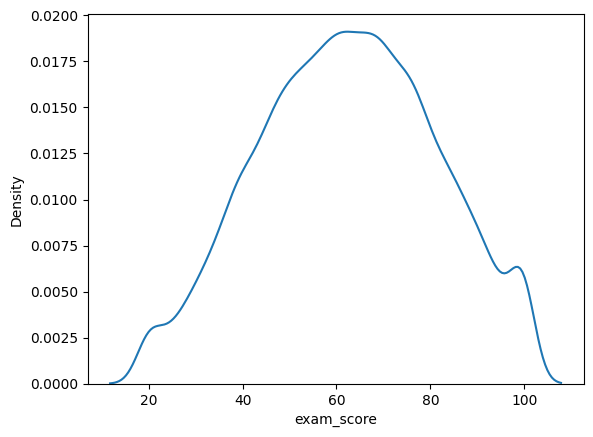

In [5]:
sns.kdeplot(df['exam_score'])

In [6]:
#Excluindo o id
df.drop('student_id', axis= 'columns', inplace = True)

Média de notas por qualidade de sono

<Axes: xlabel='sleep_quality', ylabel='exam_score'>

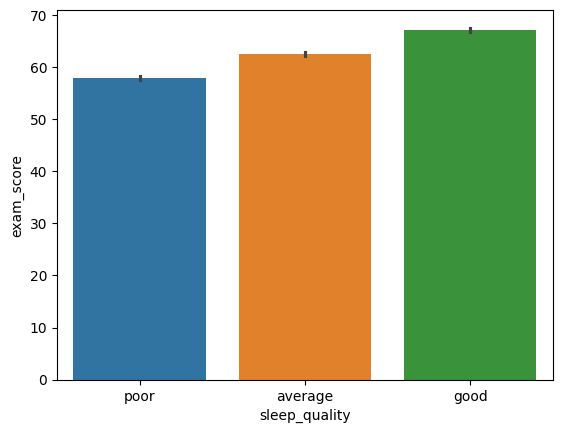

In [7]:
sns.barplot(x=df.sleep_quality, y=df.exam_score, hue=df.sleep_quality)

Media de notas por método de estudo

<Axes: xlabel='study_method', ylabel='exam_score'>

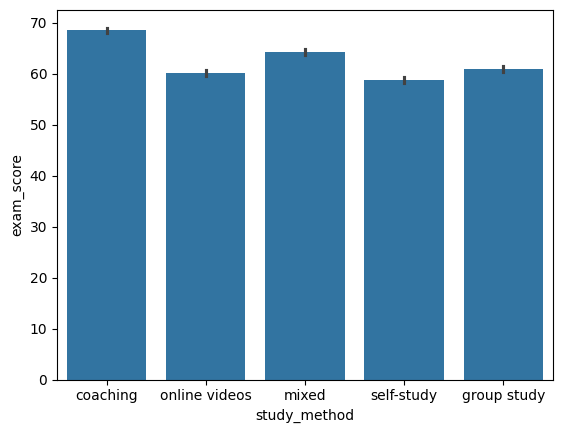

In [8]:
sns.barplot(x=df['study_method'], y=df['exam_score'])

Tendência entre horas de estudo e notas no exame

<Axes: xlabel='study_hours', ylabel='exam_score'>

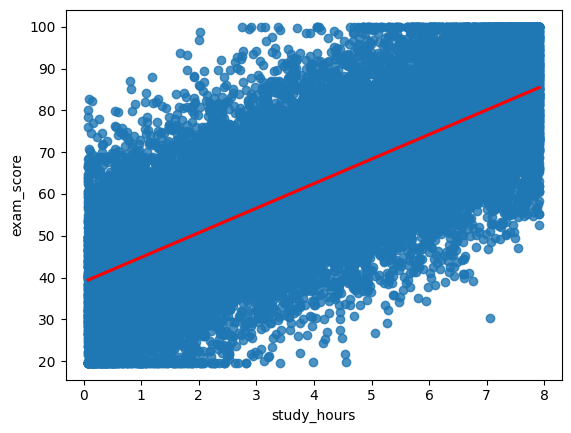

In [9]:
sns.regplot(
    x=df.study_hours, y=df.exam_score, line_kws={'color':'red'}
)

**Verificando outliers com boxplot**

Text(0.5, 1.0, 'sleep_hours')

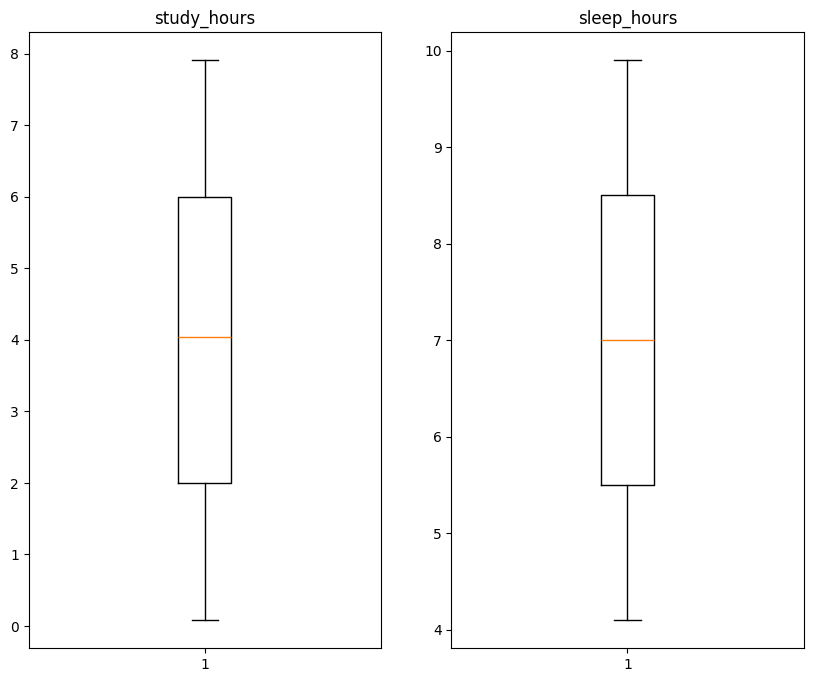

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

ax1.boxplot(df['study_hours'])
ax1.set_title("study_hours")

ax2.boxplot(df['sleep_hours'])
ax2.set_title("sleep_hours")

**Tratando variáveis categoricas**

In [11]:
#Aplicando OneHotEncoding
cat_df = df[['gender', 'sleep_quality','course','study_method']]
encoder = OneHotEncoder()
cat_df = encoder.fit_transform(cat_df)
cat_df = pd.DataFrame(cat_df.toarray(), columns=encoder.get_feature_names_out())

df.drop(['gender', 'sleep_quality','course','study_method'], axis=1, inplace=True)

df = pd.concat([df, cat_df], axis=1)

In [12]:
#Binary

df['internet_access'] = df['internet_access'].map({'yes': 1, 'no': 0})
df.internet_access.astype('int64')
df[['internet_access']]

,internet_access
0,1
1,1
2,1
3,1
4,1
...,...
19995,1
19996,0
19997,1
19998,0


In [13]:
df[['facility_rating', 'exam_difficulty']]

,facility_rating,exam_difficulty
0,low,hard
1,medium,moderate
2,high,moderate
3,low,moderate
4,low,moderate
...,...,...
19995,low,easy
19996,medium,moderate
19997,low,easy
19998,medium,moderate


In [14]:
# Ordinal Encoding
ordinal_cols = df[['facility_rating', 'exam_difficulty']].copy()

ord_enc = OrdinalEncoder(categories=[
    ['low', 'medium', 'high'],
    ['easy', 'moderate', 'hard']
])

df_ord = ord_enc.fit_transform(ordinal_cols)
df_ord = pd.DataFrame(df_ord, columns=ord_enc.get_feature_names_out())

# Remover as colunas originais de string do df
df.drop(['facility_rating', 'exam_difficulty'], axis=1, inplace=True)

# Concatenar as colunas codificadas de volta ao df
df = pd.concat([df, df_ord], axis=1)

**Seleção de features**

In [15]:
df.head()

,age,study_hours,class_attendance,internet_access,sleep_hours,exam_score,gender_female,gender_male,gender_other,sleep_quality_average,...,course_bba,course_bca,course_diploma,study_method_coaching,study_method_group study,study_method_mixed,study_method_online videos,study_method_self-study,facility_rating,exam_difficulty
0,17,2.78,92.9,1,7.4,58.9,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
1,23,3.37,64.8,1,4.6,54.8,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,22,7.88,76.8,1,8.5,90.3,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0
3,20,0.67,48.4,1,5.8,29.7,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,20,0.89,71.6,1,9.8,43.7,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         20000 non-null  int64  
 1   study_hours                 20000 non-null  float64
 2   class_attendance            20000 non-null  float64
 3   internet_access             20000 non-null  int64  
 4   sleep_hours                 20000 non-null  float64
 5   exam_score                  20000 non-null  float64
 6   gender_female               20000 non-null  float64
 7   gender_male                 20000 non-null  float64
 8   gender_other                20000 non-null  float64
 9   sleep_quality_average       20000 non-null  float64
 10  sleep_quality_good          20000 non-null  float64
 11  sleep_quality_poor          20000 non-null  float64
 12  course_b.com                20000 non-null  float64
 13  course_b.sc                 200

In [17]:
X = df.drop('exam_score', axis=1)
y = df.exam_score

In [18]:
#Aplicando o f_regression para verificar F-score e P_value
np.set_printoptions(suppress=True)

F, p_value = f_regression(X, y)

In [19]:
X.columns

Index(['age', 'study_hours', 'class_attendance', 'internet_access',
       'sleep_hours', 'gender_female', 'gender_male', 'gender_other',
       'sleep_quality_average', 'sleep_quality_good', 'sleep_quality_poor',
       'course_b.com', 'course_b.sc', 'course_b.tech', 'course_ba',
       'course_bba', 'course_bca', 'course_diploma', 'study_method_coaching',
       'study_method_group study', 'study_method_mixed',
       'study_method_online videos', 'study_method_self-study',
       'facility_rating', 'exam_difficulty'],
      dtype='object')

In [20]:
#Variáveis mais importantes para o modelo com F-score
list(zip(X.columns, np.round(F, 2)))

[('age', np.float64(0.85)),
 ('study_hours', np.float64(21253.67)),
 ('class_attendance', np.float64(2108.73)),
 ('internet_access', np.float64(1.22)),
 ('sleep_hours', np.float64(361.34)),
 ('gender_female', np.float64(0.13)),
 ('gender_male', np.float64(0.38)),
 ('gender_other', np.float64(0.06)),
 ('sleep_quality_average', np.float64(0.01)),
 ('sleep_quality_good', np.float64(610.02)),
 ('sleep_quality_poor', np.float64(611.54)),
 ('course_b.com', np.float64(0.3)),
 ('course_b.sc', np.float64(0.4)),
 ('course_b.tech', np.float64(0.18)),
 ('course_ba', np.float64(1.52)),
 ('course_bba', np.float64(1.59)),
 ('course_bca', np.float64(0.0)),
 ('course_diploma', np.float64(0.31)),
 ('study_method_coaching', np.float64(529.17)),
 ('study_method_group study', np.float64(32.66)),
 ('study_method_mixed', np.float64(40.54)),
 ('study_method_online videos', np.float64(79.99)),
 ('study_method_self-study', np.float64(207.25)),
 ('facility_rating', np.float64(545.3)),
 ('exam_difficulty', np.flo

In [21]:
#Variáveis mais importantes para o modelo com p-values
list(zip(X.columns, np.round(p_value, 2)))



[('age', np.float64(0.36)),
 ('study_hours', np.float64(0.0)),
 ('class_attendance', np.float64(0.0)),
 ('internet_access', np.float64(0.27)),
 ('sleep_hours', np.float64(0.0)),
 ('gender_female', np.float64(0.72)),
 ('gender_male', np.float64(0.54)),
 ('gender_other', np.float64(0.8)),
 ('sleep_quality_average', np.float64(0.93)),
 ('sleep_quality_good', np.float64(0.0)),
 ('sleep_quality_poor', np.float64(0.0)),
 ('course_b.com', np.float64(0.58)),
 ('course_b.sc', np.float64(0.53)),
 ('course_b.tech', np.float64(0.67)),
 ('course_ba', np.float64(0.22)),
 ('course_bba', np.float64(0.21)),
 ('course_bca', np.float64(0.97)),
 ('course_diploma', np.float64(0.58)),
 ('study_method_coaching', np.float64(0.0)),
 ('study_method_group study', np.float64(0.0)),
 ('study_method_mixed', np.float64(0.0)),
 ('study_method_online videos', np.float64(0.0)),
 ('study_method_self-study', np.float64(0.0)),
 ('facility_rating', np.float64(0.0)),
 ('exam_difficulty', np.float64(0.5))]

Baseado nos valores F e P, vemos que as variáveis mais importantes para o modelo são: *'study_hours', 'class_attendance' ,'sleep_hours', 'study_method' e 'facility_rating'*, o que faz total sentido!

As variáveis menos importantes para este dataset são: *'gender' e 'course'*, podemos tira-las do modelo.

In [22]:
X.drop(['gender_female','gender_male', 'gender_other', 'course_b.com', 'course_b.sc', 'course_b.tech', 'course_ba', 'course_bba', 'course_bca', 'course_diploma'], axis=1, inplace=True)

In [23]:
X.shape

(20000, 15)

In [24]:
X.head()

,age,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality_average,sleep_quality_good,sleep_quality_poor,study_method_coaching,study_method_group study,study_method_mixed,study_method_online videos,study_method_self-study,facility_rating,exam_difficulty
0,17,2.78,92.9,1,7.4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
1,23,3.37,64.8,1,4.6,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,22,7.88,76.8,1,8.5,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0
3,20,0.67,48.4,1,5.8,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,20,0.89,71.6,1,9.8,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         20000 non-null  int64  
 1   study_hours                 20000 non-null  float64
 2   class_attendance            20000 non-null  float64
 3   internet_access             20000 non-null  int64  
 4   sleep_hours                 20000 non-null  float64
 5   sleep_quality_average       20000 non-null  float64
 6   sleep_quality_good          20000 non-null  float64
 7   sleep_quality_poor          20000 non-null  float64
 8   study_method_coaching       20000 non-null  float64
 9   study_method_group study    20000 non-null  float64
 10  study_method_mixed          20000 non-null  float64
 11  study_method_online videos  20000 non-null  float64
 12  study_method_self-study     20000 non-null  float64
 13  facility_rating             200

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [27]:
#Testando os melhores hiperparametros para o modelo
param_grid = {
    "n_estimators": [50, 100, 150, 200, 250, 300],
    "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.1],
    "max_depth": [3, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.1]
}

In [28]:
grid_search = GridSearchCV(estimator = XGBRegressor(), param_grid=param_grid, cv = 3, scoring = "neg_mean_absolute_error", verbose=1)

In [29]:
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 480 candidates, totalling 1440 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 0.1],
                         'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.1],
                         'max_depth': [3, 7],
                         'n_estimators': [50, 100, 150, 200, 250, 300],
                         'subsample': [0.8, 1.0]},
             scoring='neg_mean_absolute_error', verbose=1)

In [30]:
grid_search.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.04,
 'max_depth': 3,
 'n_estimators': 300,
 'subsample': 0.8}

Ajustando alguns parâmetros para melhorar ainda mais

In [31]:
model = XGBRegressor(
  colsample_bytree = 0.9,
 gamma = 0,
 learning_rate = 0.04,
 max_depth = 3,
 n_estimators = 300,
 subsample= 0.8)

In [32]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.04, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [33]:
y_pred = model.predict(X_test)

Score do modelo

In [34]:
mean_absolute_error(y_test, y_pred)

7.929400741580964

In [35]:
mean_squared_error(y_test, y_pred)

96.6837235250258

In [36]:
r2_score(y_test, y_pred)*100

72.87261774737624

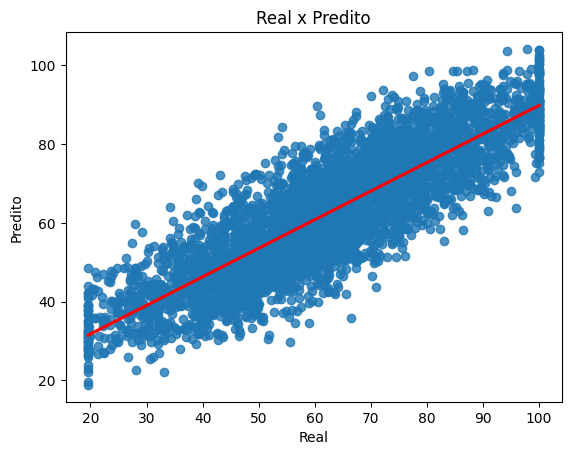

In [38]:
sns.regplot( x=y_test, y=y_pred, line_kws={'color': 'red'})
plt.xlabel('Real')
plt.ylabel('Predito')
plt.title('Real x Predito')
plt.show()